In [414]:
using SpecialFunctions
using QuantumOptics

function fidelity(ρ, σ)
    tr(sqrt(sqrt(ρ) * σ * sqrt(ρ)))^(1/2)
end

function R(n::Int64, m::Int64, ρ::Float64)
    if (n - m) % 2 != 0
        0
    else
        function summand(k)
            n = big(n)
            k = big(k)
            (-1)^k * factorial(n-k)/(factorial(k)*factorial(Int((n+m)/2) - k)*factorial(Int((n-m)/2) - k))*(ρ)^(n-2*k)
        end
        mapreduce(summand, +, Array(range(0, stop=Int((n-m)/2), step=1)))
    end
end

function plot_across_unit_disk(f, discretization)
    x = y = Array(range(-1, 1, length=discretization))
    z = Array{typeof(f(0.,0.))}(UndefInitializer(), length(x), length(y))
    for (i, xx) in enumerate(x)
        for (j, yy) in enumerate(y)
            #print("Plotting cell" * string(xx) * "," * string(yy) * "...")
            if xx^2 + yy^2 > 1
                if typeof(f(0.,0.)) == Tuple{Float64,Float64}
                    z[i, j] = (0.,0.)
                else
                    z[i, j] = 0.
                end
            else
                ρ = sqrt(xx^2 + yy^2)
                ϕ = atan(yy, xx)
                res = f(ρ, ϕ)
                z[i, j] = res
            end
        end
    end
    x, y, z
end

function unpack_zernike(zernike_coefficients_even, zernike_coefficients_odd, ρ, ω, t)
    """Each Zernike array is of arbitrary length, but they are ordered by order. The first is Z00 to Zn0 where
    n is the number of 0th order zernike polynomials being considered."""
    Pevens = []
    eventuples = []
    for (n, zeven) in enumerate(zernike_coefficients_even)
        neven = n - 1
        # THERE WAS A BUG IN THE LEGNTH(ZEVEN). IT SHOULD BE RIGHT NOW.
        push!(Pevens, [zeven[i] * R(neven, i-1, ρ) for i in Array(range(1, length(zeven), step=1))])
    end
    for i in range(1, length(Pevens), step=1)
        rotationeven = - (i - 1) * ω * t
        total = 0
        for peven in Pevens
            if length(peven) >= i
                total += peven[i]
            end
        end    
        push!(eventuples, (i - 1, total, rotationeven))
    end

    Podds = []
    oddtuples = []
    for (n, zodd) in enumerate(zernike_coefficients_odd)
        nodd = n - 1
        push!(Podds, [zodd[i] * R(nodd, i-1, ρ) for i in Array(range(1, length(zodd), step=1))])
    end
    for i in range(1, length(Podds), step=1)
        rotationodd = - (i - 1) * ω * t
        total = 0
        for podd in Podds
            if length(podd) >= i
                total += podd[i]
            end
        end    
        push!(oddtuples, (i - 1, total, rotationodd))
    end
    eventuples, oddtuples
end

toarray(s::Union{Set, Array}) = [toarray.(s)...]
toarray(v::Number) = v

toarray (generic function with 2 methods)

In [415]:
function H_odf(ρ, ϕ, t, zernike_coefficients_even, zernike_coefficients_odd, U, ψ, μ, ω)
    eventuples, oddtuples = unpack_zernike(zernike_coefficients_even, zernike_coefficients_odd, ρ, ω, t)
    eventerm = oddterm = 0
    if length(eventuples) > 0
        eventerm = mapreduce(x->x[2]*cos(x[1]*ϕ + x[3]), +, eventuples)
    end
    if length(oddtuples) > 0
        oddterm = mapreduce(x->x[2]*sin(x[1]*ϕ + x[3]), +, oddtuples)
    end
    U * cos(-μ*t + ψ + eventerm + oddterm) 
end

H_odf (generic function with 1 method)

In [416]:
function H_odf_RWA(ρ, ϕ, t, zernike_coefficients_even, zernike_coefficients_odd, U, ψ, ω, m)
    if length(zernike_coefficients_even) > m
        zernike_coefficients_even = vcat([[0] for _ in range(1, m, step=1)], [zernike_coefficients_even[m + 1]])
    else
        zernike_coefficients_even = []
    end
    if length(zernike_coefficients_odd) > m
        zernike_coefficients_odd = vcat([[0] for _ in range(1, m, step=1)], [zernike_coefficients_odd[m + 1]])
    else
        zernike_coefficients_odd = []
    end
    eventuples, oddtuples = unpack_zernike(zernike_coefficients_even, zernike_coefficients_odd, ρ, ω, t) 
    p = q = 0
    if length(eventuples) > 0
        p = eventuples[length(eventuples)][2]
    end
    if length(oddtuples) > 0
        q = oddtuples[length(oddtuples)][2]
    end
    U * besselsum(p, q, -m * ϕ + ψ)
end    

function H_odf_RWA_small(ρ, ϕ, t, zernike_coefficients_even, zernike_coefficients_odd, U, ψ, ω, m)
    if length(zernike_coefficients_even) > m
        zernike_coefficients_even = vcat([[0] for _ in range(1, m, step=1)], [zernike_coefficients_even[m + 1]])
    else
        zernike_coefficients_even = []
    end
    if length(zernike_coefficients_odd) > m
        zernike_coefficients_odd = vcat([[0] for _ in range(1, m, step=1)], [zernike_coefficients_odd[m + 1]])
    else
        zernike_coefficients_odd = []
    end
    eventuples, oddtuples = unpack_zernike(zernike_coefficients_even, zernike_coefficients_odd, ρ, ω, t) 
    p = q = 0
    if length(eventuples) > 0
        p = eventuples[length(eventuples)][2]
    end
    if length(oddtuples) > 0
        q = oddtuples[length(oddtuples)][2]
    end
    U/2 * (p * sin(m*ϕ - ψ) - q * cos(m*ϕ - ψ))
end    

H_odf_RWA_small (generic function with 1 method)

In [417]:
function besselsum(p, q, θ)
    ret = besselj(0, p)*besselj(-1, q)*cos(θ)
    i = 1
    nextterm = 1
    while i < 100
        nextterm = besselterm(i, p, q, θ)
        i += 1
        ret += nextterm
    end
    ret
end

function besselterm(n, p, q, θ)
    besselj(n, p)*besselj(-(n+1), q)*cos(n*π/2 + θ) + besselj(-n, p)*besselj(n-1, q)*cos(-n*π/2 + θ) #?
end

besselterm (generic function with 1 method)

In [418]:
Γ = 1/62
ω = 2*π*180E3
#ω = 2*π*43.8E3
U = 2*π*10E3
θ = 0.;

In [501]:
b = SpinBasis(1//2)
ψ0 = 1/sqrt(2) * (spindown(b) + spinup(b))
evolution_time = 110.0E-6
step_size = evolution_time/100
T = [0.0:step_size:evolution_time;]
zernikeeven = []#[[0.], [0., 1.]];
zernikeodd = [[0.], [0., 1.]];
order = 0
μ = order * ω

0.0

In [496]:
ρ = 1.
ϕ = 0
H(t, _) = H_odf(ρ, ϕ, t, zernikeeven, zernikeodd, U, θ, μ, ω)*sigmaz(b), [sigmam(b)], [dagger(sigmam(b))]
tout, ψ = timeevolution.master_dynamic(T, ψ0, H; rates=[Γ])

# Measure in the x basis
excitation = Real.(expect(sigmax(b), ψ));

In [497]:
H(t, _) = H_odf_RWA(ρ, ϕ, t, zernikeeven, zernikeodd, U, θ, ω, order)*sigmaz(b), [sigmam(b)], [dagger(sigmam(b))]
tout, ψ = timeevolution.master_dynamic(T, ψ0, H; rates=[Γ])

# Measure in the x basis
rwa = Real.(expect(sigmax(b), ψ));

In [498]:
H(t, _) = H_odf_RWA_small(ρ, ϕ, t, zernikeeven, zernikeodd, U, θ, ω, order)*sigmaz(b), [sigmam(b)], [dagger(sigmam(b))]
tout, ψ = timeevolution.master_dynamic(T, ψ0, H; rates=[Γ])

# Measure in the x basis
small = Real.(expect(sigmax(b), ψ));

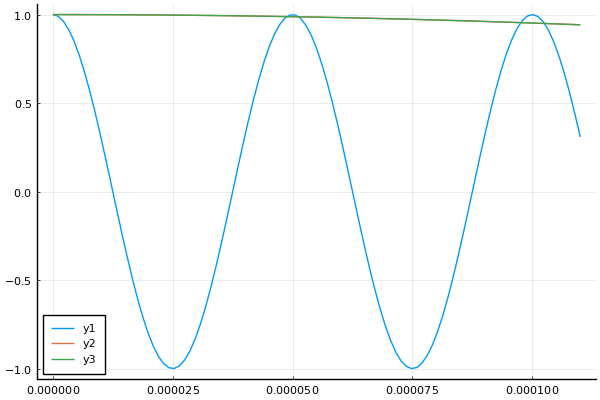

In [499]:
using Plots; pyplot()
plot(T, [excitation, rwa, small])

In [424]:
function evolution_evaluator_factory(ψ0, T, zernikeeven, zernikeodd, U, ψ, μ, ω, b)
    function evaluator(ρ, ϕ)
        H(t, _) = H_odf(ρ, ϕ, t, zernikeeven, zernikeodd, U, ψ, μ, ω)*sigmaz(b), [sigmam(b)], [dagger(sigmam(b))]
        _, ψTARGET = timeevolution.master_dynamic(T, ψ0, H; rates=[Γ])
        last(ψTARGET)
    end
end
exact_evolution_evaluator = evolution_evaluator_factory(ψ0, T, zernikeeven, zernikeodd, U, θ, μ, ω, b)

function rwa_evolution_evaluator_factory(ψ0, T, zernikeeven, zernikeodd, U, ψ, ω, b, m)
    function evaluator(ρ, ϕ)
        H(t, _) = H_odf_RWA(ρ, ϕ, t, zernikeeven, zernikeodd, U, ψ, ω, m)*sigmaz(b), [sigmam(b)], [dagger(sigmam(b))]
        _, ψTARGET = timeevolution.master_dynamic(T, ψ0, H; rates=[Γ])
        last(ψTARGET)
    end
end
rwa_evolution_evaluator = rwa_evolution_evaluator_factory(ψ0, T, zernikeeven, zernikeodd, U, θ, ω, b, order)

function rwa_small_evolution_evaluator_factory(ψ0, T, zernikeeven, zernikeodd, U, ψ, ω, b, m)
    function evaluator(ρ, ϕ)
        H(t, _) = H_odf_RWA_small(ρ, ϕ, t, zernikeeven, zernikeodd, U, ψ, ω, m)*sigmaz(b), [sigmam(b)], [dagger(sigmam(b))]
        _, ψTARGET = timeevolution.master_dynamic(T, ψ0, H; rates=[Γ])
        last(ψTARGET)
    end
end
rwa_small_evolution_evaluator = rwa_small_evolution_evaluator_factory(ψ0, T, zernikeeven, zernikeodd, U, θ, ω, b, order)


function infidelity_across_disk(F1, F2)
    function infidelity_polar(ρ, ϕ)
        ψ1 = F1(ρ, ϕ).data
        ψ2 = F2(ρ, ϕ).data
        1 - real(fidelity(ψ1, ψ2))
    end
end

infidelity_across_disk (generic function with 1 method)

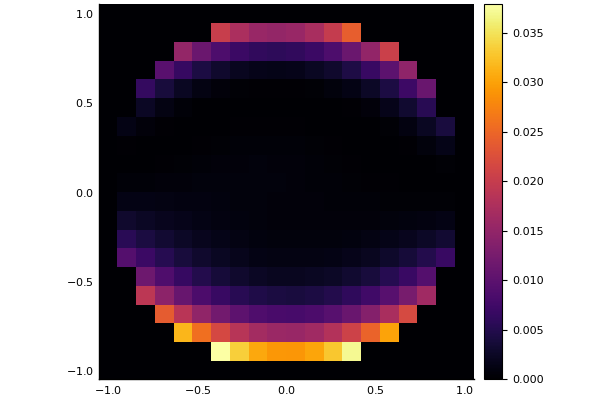

In [425]:
discretization = 20
plot(heatmap(plot_across_unit_disk(infidelity_across_disk(exact_evolution_evaluator, rwa_small_evolution_evaluator), discretization)), aspectratio = true)

# Something is incredibly sensitive to the frequency, increasing it by a factor of ten supressess the infidelity by several orders of magnitude

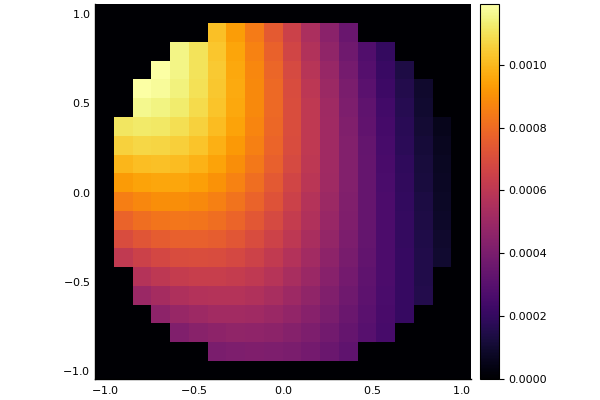

In [426]:
plot(heatmap(plot_across_unit_disk(infidelity_across_disk(exact_evolution_evaluator, rwa_evolution_evaluator), discretization)), aspectratio = true)

# Now we want to support applying multiple orders

In [427]:
function sequential_exact_evolution_evaluator_factory(ψ0, T, zernikeeven, zernikeodd, U, θ, ω, b)
    """Apply all the zernike coefficients given, in order, for time T each."""
    orders = range(0, max(length(zernikeeven), length(zernikeodd)) + 1, step=1)
    function evaluator(ρ, ϕ)
        # Keep this in the definition :).
        ψ = ψ0
        for order in orders
            μ = order * ω
            H(t, _) = H_odf(ρ, ϕ, t, zernikeeven, zernikeodd, U, θ, μ, ω)*sigmaz(b), [sigmam(b)], [dagger(sigmam(b))]
            _, ψ = timeevolution.master_dynamic(T, ψ, H; rates=[Γ])
            ψ = last(ψ)
        end
        ψ
    end
end

sequential_exact_evolution_evaluator_factory (generic function with 1 method)

In [428]:
function Z_polynomial(n::Int64)
    """Coefficients for Z_j^0, from low degree to high degree."""
    function summand(k)
        n = big(n)
        k = big(k)
        # The normalization in the front seems right, according to Wikipedia.
        (-1)^k * factorial(n-k)/(factorial(k)*factorial(Int(n/2) - k)*factorial(Int((n)/2) - k))
    end
    res = []
    for i in Array(range(0, stop=Int(n/2), step=1))
        push!(res, summand(i))
    end
    reverse(res)
end

Z_polynomial (generic function with 1 method)

In [429]:
using Combinatorics
function gaussian_coefficients(n, σ)
    """Integral of a Gaussian against an nth order polynomial from 0 to 1, times 2pi. n must be odd."""
    total = BigFloat(0)
    n = big(n)
    total = 1/2 * σ^2 * doublefactorial(n - 1) * (σ^2/2)^((n-1)/2)
    for i in range(0, Int64((n-1)/2), step = 1)
        total += -1/2 * σ^2 * exp(-1/σ^2) * (σ^2/2)^(i) * doublefactorial(n-1)/doublefactorial(n - 1 - 2 * i)
    end
    2 * π * total
end

gaussian_coefficients (generic function with 1 method)

In [430]:
# I think we have numerical errors... for large σ

In [431]:
function zernike_gaussian_coefficients(σ, m)
    """Try to reconstruct a gaussian, using Zernike polynomials up to order m"""
    coeffs = []
    for n in collect(2 * range(0, m/2, step=1))
        coeff = 0
        for (i, coefficient) in enumerate(Z_polynomial(Int64(n)))
            scalar = (2 * n + 2)
            if n == 0
                scalar /= (2)
            end
            coeff += coefficient * gaussian_coefficients(2 * i - 1, σ) * scalar
        end
        push!(coeffs, coeff)
    end
    coeffs /= sum([coeff * (-1)^(n+1) for (n, coeff) in enumerate(coeffs)])
end

function reconstruct_gaussian(ρ, σ, m)
    """Try to reconstruct a gaussian, using Zernike polynomials up to order m"""
    total = BigFloat(0)
    coeffs = zernike_gaussian_coefficients(σ, m)
    for (i, coeff) in enumerate(coeffs)
        total += coeff * (R(Int64(2*i - 2), 0, ρ)) # THIS WAS THE PROBLEM. MAKE SURE YOU'RE DOING THE MATH RIGHT.
    end
    total
end

reconstruct_gaussian (generic function with 1 method)

In [540]:
function gaussian_spin_profile_evaluator(scale)
    function gaussian_spin_profile(ρ, ϕ)
    ψ0 = 1/sqrt(2) * (spindown(b) + spinup(b))
    H(t, _) = scale * U * cos(exp(-ρ^2/σ^2)) * sigmaz(b), [sigmam(b)], [dagger(sigmam(b))]
    _, ψ = timeevolution.master_dynamic(T, ψ0, H; rates=[Γ])
    last(ψ)
    end
end

gaussian_spin_profile_evaluator (generic function with 1 method)

In [541]:
function constant_spin_profile(ρ, ϕ)
    ψ0 = 1/sqrt(2) * (spindown(b) + spinup(b))
    ψ0 ⊗ dagger(ψ0)
end

constant_spin_profile (generic function with 1 method)

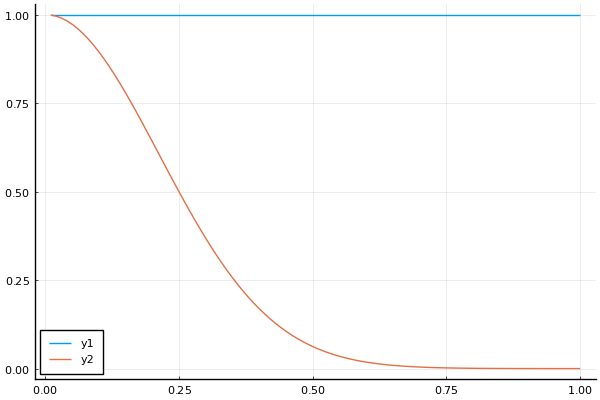

In [542]:
using Plots
max_ρ = 1
min_ρ = .01
σ = .3
ρs = range(min_ρ, max_ρ, step=max_ρ/100)
target = [exp(-ρ^2/σ^2) for ρ in ρs];
max_n = 1
ys = [reconstruct_gaussian(ρ, σ, max_n) for ρ in ρs];
plot(ρs, [ys, target])

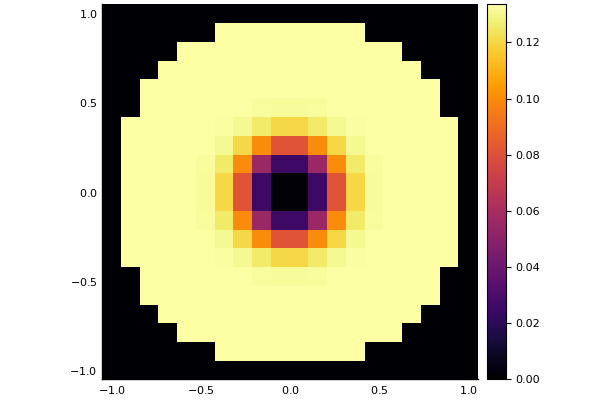

In [543]:
scale = 1
zernikeeven = [[scale*el] for el in zernike_gaussian_coefficients(σ, max_n)]
evolution_time = 25.0E-6
step_size = evolution_time/100
T = [0.0:step_size:evolution_time;]
exact_evolution_evaluator = evolution_evaluator_factory(ψ0, T, zernikeeven, [], U, θ, 0., ω, b)
plot(heatmap(plot_across_unit_disk(infidelity_across_disk(gaussian_spin_profile_evaluator(scale), exact_evolution_evaluator), discretization)), aspectratio = true)

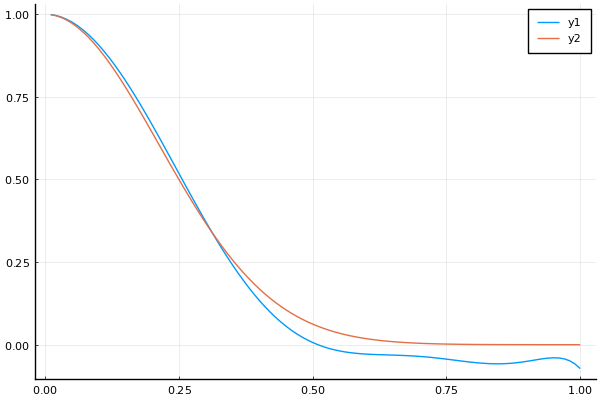

In [544]:
max_n = 10
ys = [reconstruct_gaussian(ρ, σ, max_n) for ρ in ρs];
plot(ρs, [ys, target])

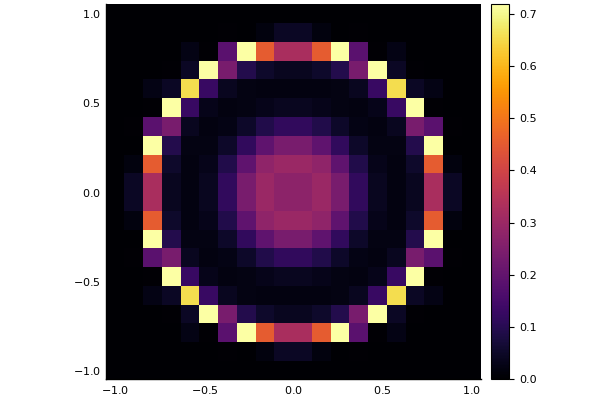

In [548]:
evolution_time = 25.0E-6
step_size = evolution_time/100
T = [0.0:step_size:evolution_time;]
zernikeeven = [[acos(el)] for el in zernike_gaussian_coefficients(σ, max_n)]
exact_evolution_evaluator = evolution_evaluator_factory(ψ0, T, zernikeeven, [], U, θ, 0., ω, b)
plot(heatmap(plot_across_unit_disk(infidelity_across_disk(gaussian_spin_profile_evaluator(1), exact_evolution_evaluator), discretization)), aspectratio = true)

# 9/2
# Closing notes, next steps. There was a bug that was preventing correct answers - I wasn't summing over all of the zernike terms in unpack zernike. Thus the thing was constant across R. Now what is the state? There is a chance I've hacked things apart. zernikeeven and zernikeodd may need to be switched, but to the best of my knowledge everything should be working, so the next step should be to make sure the RWA bits work, and then make sure that the exact time evolution works.

# 9/4 Closing notes. I went back, and fixed a lot of errors. The order of applying R's should now be correct, but notice that we still haven't sequentially applied zernikes. The conclusion from the Gaussian work (while an enlightening exercise, as working with ideas is) is that we should probably just implement the general decomposition. The Gaussian example is only order 0 polynomials, so they're all DC. Moreover, this has a strange consequence - those terms are related by an inverse cosine, since the rotating bit doesn't apply. Moreover, we need to "calibrate" to make sure that the pi time at the center is right.